<a href="https://colab.research.google.com/github/reagan13/gpt2-distilbert-thesis-files/blob/main/notebook/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIP#


Python library used for evaluating sequence labeling tasks, such as Named Entity Recognition (NER) and part-of-speech tagging.


In [3]:
!pip install seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=805391ddaab34ffbd2eb5b8159b043409bf36065b38e79462157309dbdc096c9
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


Uploading Dataset


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving final_dataset.json to final_dataset.json


# Import libraries


This code imports necessary libraries for working with PyTorch, data visualization, evaluation metrics, and JSON handling.


In [4]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2TokenizerFast, GPT2Model, GPT2Config, AdamW, get_linear_schedule_with_warmup
from typing import Dict, List, Optional, Tuple
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from seqeval.metrics import precision_score as seq_precision, recall_score as seq_recall, f1_score as seq_f1
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmaps
import os
from google.colab import drive
from tabulate import tabulate
import time # Import the time module

# For sequence evaluation (NER)
from seqeval.metrics import f1_score as seq_f1

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Current date and time for output directory naming
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

NameError: name 'np' is not defined

## Mount To GDrive (Optional)


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
SAVE_PATH = "/content/drive/MyDrive/gpt2_baseline_model_freeze_d2"
os.makedirs(SAVE_PATH, exist_ok=True)


Mounted at /content/drive


# Functions


## Load dataset


It defines a function load_dataset that loads and returns a dataset from a specified JSON file. The function reads the JSON file, parses its content, and outputs it as a list of dictionaries.


In [23]:
# Load dataset
def load_dataset(json_file: str) -> List[Dict]:
    with open(json_file, 'r', encoding='utf-8') as f:
        return json.load(f)


## Detect and Mapping the labels


This code defines the detect_labels function, which processes a dataset to identify unique categories, intents, and named entity recognition (NER) labels. The function iterates through each sample in the dataset, extracting and adding unique values to sets for categories, intents, and NER labels. It also creates mappings (encoders) to assign an integer index to each unique category, intent, and NER label, which are then returned as a dictionary. The function prints out the encoders for categories, intents, and NER labels.


In [26]:
# Updated detect_labels to use BIO scheme like HybridFusionMultiTask
def detect_labels(data: List[Dict]) -> Dict[str, Dict]:
    unique_categories = set()
    unique_intents = set()
    unique_ner_labels = set(["O"])  # "O" is the default label for tokens outside entities

    for sample in data:
        unique_categories.add(sample["category"])
        unique_intents.add(sample["intent"])
        ner_labels = sample["ner_labels_only"]  # Convert string to list of dicts
        # ner_labels = json.loads(ner_labels) # Parse string to list of dictionaries
        for label in ner_labels:
            label_type = label["label"]
            unique_ner_labels.add(f"B-{label_type}")  # Add "B-" prefix for beginning of entity
            unique_ner_labels.add(f"I-{label_type}")  # Add "I-" prefix for inside of entity

    category_encoder = {cat: idx for idx, cat in enumerate(sorted(unique_categories))}
    intent_encoder = {intent: idx for idx, intent in enumerate(sorted(unique_intents))}
    ner_label_encoder = {ner: idx for idx, ner in enumerate(sorted(unique_ner_labels))}

    print("Category encoder:", category_encoder)
    print("Intent encoder:", intent_encoder)
    print("NER label encoder:", ner_label_encoder)

    return {
        "category_encoder": category_encoder,
        "intent_encoder": intent_encoder,
        "ner_label_encoder": ner_label_encoder
    }




## Tokenize the text


This code is a function that tokenizes input text using GPT-2tokenizers. It processes the text by truncating or padding it to a maximum length, and returns tokenized outputs in the form of input_ids and attention_mask for the model. These tokenized inputs are then ready to be fed into the model for multitask learning.


In [5]:
# Tokenization
def tokenize_text_gpt2(text: str, gpt2_tokenizer, max_length: int = 128) -> Dict[str, torch.Tensor]:

    gpt2_inputs = gpt2_tokenizer(
        text, max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
        )
    return {"gpt2_input_ids": gpt2_inputs["input_ids"].squeeze(0),
            "gpt2_attention_mask": gpt2_inputs["attention_mask"].squeeze(0)}


## Aligning Ner Labels


The align_ner_labels function aligns Named Entity Recognition (NER) labels with tokenized input from GPT2. It tokenizes the text, maps each token to its character offset, and then assigns appropriate NER labels based on the positions of entities in the text. It ensures that the labels are correctly aligned with the tokens, using the BIO (Begin, Inside, Outside) scheme. The function returns a list of integers representing the aligned NER labels, which can then be used for training or evaluation.


In [29]:
# Align NER labels
def align_ner_labels(text: str, ner_labels: str, tokenizer, ner_label_encoder: Dict, max_length: int = 128) -> List[int]:
    # ner_labels = json.loads(ner_labels)
    encoding = tokenizer(text, max_length=max_length, padding="max_length", truncation=True, return_offsets_mapping=True, return_tensors="pt")
    tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
    token_to_char_map = encoding["offset_mapping"][0].tolist()
    ner_aligned = [ner_label_encoder["O"]] * len(tokens)

    for label in ner_labels:
        label_text, label_type = label["text"], label["label"]
        label_start = text.find(label_text)
        if label_start == -1:
            continue
        label_end = label_start + len(label_text)
        for i, (start, end) in enumerate(token_to_char_map):
            if start == 0 and end == 0:
                continue
            if start >= label_start and end <= label_end:
                prefix = "B-" if ner_aligned[i] == ner_label_encoder["O"] else "I-"
                ner_aligned[i] = ner_label_encoder[f"{prefix}{label_type}"]

    return ner_aligned[:max_length]


# Class (Custom Dataset and DataLoader)

## Custom Dataset


The MultiTaskDataset class is a custom dataset for multitask learning, designed to handle text data for Intent Classification, Category Classification, and Named Entity Recognition (NER). It tokenizes the input text using GPT-2 tokenizers, aligns the NER labels with the tokenized text, and encodes the labels (category, intent, NER) using provided label encoders. The dataset returns tokenized inputs for both models and the associated labels as tensors for training in multitask settings.


In [30]:
class MultiTaskDataset(Dataset):
    def __init__(self, data: List[Dict], gpt2_tokenizer, label_encoders, max_length: int = 128):
        self.data = data
        self.gpt2_tokenizer = gpt2_tokenizer
        self.label_encoders = label_encoders
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        text = sample["instruction"]

        gpt2_inputs = tokenize_text_gpt2(text, self.gpt2_tokenizer, self.max_length)

        return {
            "input_ids": gpt2_inputs["gpt2_input_ids"],
            "attention_mask": gpt2_inputs["gpt2_attention_mask"],
            "category_labels": torch.tensor(self.label_encoders["category_encoder"][sample["category"]], dtype=torch.long),
            "intent_labels": torch.tensor(self.label_encoders["intent_encoder"][sample["intent"]], dtype=torch.long),
            "ner_labels": torch.tensor(
                align_ner_labels(text, sample["ner_labels_only"], self.gpt2_tokenizer,
                                 self.label_encoders["ner_label_encoder"], self.max_length),
                dtype=torch.long
            )
        }



## Data Loader


The get_dataloaders function creates DataLoader objects for the training, validation, and test datasets. It initializes MultiTaskDataset for each dataset and then creates corresponding DataLoader instances with specified batch sizes and the number of workers for parallel data loading. These DataLoaders are used to efficiently load data in batches during model training and evaluation.


In [31]:
# DataLoader setup
# change pin_memory to false if using CPU
def get_dataloaders(train_data, val_data, test_data, gpt2_tokenizer, label_encoders, batch_size=16, num_workers=2, pin_memory=True):
    train_dataset = MultiTaskDataset(train_data, gpt2_tokenizer, label_encoders)
    val_dataset = MultiTaskDataset(val_data, gpt2_tokenizer, label_encoders)
    test_dataset = MultiTaskDataset(test_data, gpt2_tokenizer, label_encoders)

    return (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory),
        DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
    )


# Model Architecture


This code defines a multi-task learning model, BaselineGPT2MultiTask, which uses a pre-trained GPT-2 model for three tasks: intent classification, category classification, and named entity recognition (NER). The GPT-2 model is frozen (its parameters are not updated during training) by setting requires_grad = False for all its parameters. The model extracts features from GPT-2 and processes them through task-specific heads to generate logits for each task. If labels are provided, it computes the loss for all tasks. The model also includes methods to save and load its state.


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Model, GPT2Config
from typing import Dict, Optional, List, Union, Tuple
import math

class BaselineGPT2MultiTask(nn.Module):
    """
    Multi-task learning model based on GPT-2 for simultaneous intent classification,
    category classification, and named entity recognition (NER).

    This model implements several enhancements over the baseline:
    1. Layer-wise fine-tuning: Only fine-tunes the last n layers of GPT-2
    2. Task-weighted loss function: Dynamically balances losses across tasks
    3. Enhanced NER architecture: More complex head for token classification
    4. Support for discriminative learning rates during optimization
    """

    def __init__(
        self,
        num_intents: int,
        num_categories: int,
        num_ner_labels: int,
        num_layers_to_finetune: int = 3,  # Number of GPT-2 layers to fine-tune
        dropout_rate: float = 0.2,
        task_weights: Optional[Dict[str, float]] = None,
        use_dynamic_task_weights: bool = False
    ):
        """
        Initialize the improved GPT-2 multi-task model.

        Args:
            num_intents: Number of intent classes
            num_categories: Number of category classes
            num_ner_labels: Number of NER labels (including O and BIO prefixes)
            num_layers_to_finetune: Number of GPT-2 layers to unfreeze for fine-tuning (from the top)
            dropout_rate: Dropout rate for regularization
            task_weights: Optional dictionary with initial weights for tasks {'intent': w1, 'category': w2, 'ner': w3}
            use_dynamic_task_weights: Whether to learn task weights during training
        """
        super().__init__()

        # Load GPT-2 configuration and model
        self.config = GPT2Config.from_pretrained('gpt2')
        self.gpt2 = GPT2Model.from_pretrained('gpt2')
        hidden_size = self.config.n_embd

        # Implement layer-wise fine-tuning
        # First, freeze all parameters
        for param in self.gpt2.parameters():
            param.requires_grad = False

        # Then, selectively unfreeze the last n transformer layers
        if num_layers_to_finetune > 0:
            num_layers = len(self.gpt2.h)
            for i in range(num_layers - num_layers_to_finetune, num_layers):
                for param in self.gpt2.h[i].parameters():
                    param.requires_grad = True

        # Intent classification head
        self.intent_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_intents)
        )

        # Category classification head
        self.category_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_categories)
        )

        # Enhanced NER head with deeper architecture
        self.ner_head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(hidden_size//2, num_ner_labels)
        )

        # Task weighting
        self.use_dynamic_task_weights = use_dynamic_task_weights

        if task_weights:
            self.task_weights = task_weights
        else:
            # Default to equal weighting if not provided
            self.task_weights = {'intent': 1.0, 'category': 1.0, 'ner': 1.0}

        # For dynamic task weighting (learnable weights)
        if use_dynamic_task_weights:
            # Initialize log variance parameters for each task
            self.log_vars = nn.Parameter(torch.zeros(3))  # One for each task

    def get_task_weights(self) -> Dict[str, float]:
        """
        Return the current task weights used by the model.

        Returns:
            Dictionary containing task weights for 'intent', 'category', and 'ner'
        """
        if self.use_dynamic_task_weights:
            # Calculate weights based on learned log variances (uncertainty weighting)
            weights = torch.exp(-self.log_vars)
            return {
                'intent': weights[0].item(),
                'category': weights[1].item(),
                'ner': weights[2].item()
            }
        else:
            return self.task_weights

    def get_finetune_parameters(self) -> List[Dict[str, Union[List[nn.Parameter], float]]]:
        """
        Returns parameters grouped for discriminative learning rates.

        Returns:
            List of parameter dictionaries with their corresponding learning rates
        """
        # This enables discriminative learning rates during optimization
        gpt2_params = []
        head_params = []

        # Collect unfrozen GPT-2 parameters
        for name, param in self.gpt2.named_parameters():
            if param.requires_grad:
                gpt2_params.append(param)

        # Collect task head parameters
        for name, param in self.named_parameters():
            if 'gpt2' not in name and 'log_vars' not in name:
                head_params.append(param)

        # Group parameters
        return [
            {'params': gpt2_params, 'lr_multiplier': 0.1},  # Lower learning rate for GPT-2
            {'params': head_params, 'lr_multiplier': 1.0}   # Higher learning rate for heads
        ]

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        intent_labels: Optional[torch.Tensor] = None,
        category_labels: Optional[torch.Tensor] = None,
        ner_labels: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        """
        Forward pass through the multi-task model.

        Args:
            input_ids: Tokenized input tensor
            attention_mask: Attention mask tensor
            intent_labels: Optional intent labels for loss calculation
            category_labels: Optional category labels for loss calculation
            ner_labels: Optional NER labels for loss calculation

        Returns:
            Dictionary containing logits for each task and combined loss (if labels provided)
        """
        # Get GPT-2 hidden states
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        # Get the last non-padding token representation for classification tasks
        sequence_lengths = attention_mask.sum(dim=1) - 1  # -1 because indices are 0-based
        batch_size = sequence_output.shape[0]

        # Create indices to gather the last non-padded token for each sequence
        last_token_indexes = sequence_lengths.unsqueeze(-1).unsqueeze(-1).repeat(
            1, 1, sequence_output.shape[-1]
        )

        # Extract the final representation for classification tasks
        sequence_repr = torch.gather(sequence_output, 1, last_token_indexes).squeeze(1)

        # Pass through task-specific heads
        intent_logits = self.intent_head(sequence_repr)
        category_logits = self.category_head(sequence_repr)
        ner_logits = self.ner_head(sequence_output)

        # Calculate loss if labels are provided
        loss = None
        task_losses = {}

        if all(label is not None for label in [intent_labels, category_labels, ner_labels]):
            # Intent classification loss
            intent_loss = F.cross_entropy(intent_logits, intent_labels)
            task_losses['intent'] = intent_loss

            # Category classification loss
            category_loss = F.cross_entropy(category_logits, category_labels)
            task_losses['category'] = category_loss

            # NER loss - only consider non-padding tokens
            active_loss = attention_mask.view(-1) == 1
            active_logits = ner_logits.view(-1, ner_logits.size(-1))[active_loss]
            active_labels = ner_labels.view(-1)[active_loss]
            ner_loss = F.cross_entropy(active_logits, active_labels)
            task_losses['ner'] = ner_loss

            # Apply task weighting
            if self.use_dynamic_task_weights:
                # Dynamic uncertainty weighting
                precision = torch.exp(-self.log_vars)
                loss = (
                    precision[0] * intent_loss + 0.5 * self.log_vars[0] +
                    precision[1] * category_loss + 0.5 * self.log_vars[1] +
                    precision[2] * ner_loss + 0.5 * self.log_vars[2]
                )
            else:
                # Fixed weighting
                loss = (
                    self.task_weights['intent'] * intent_loss +
                    self.task_weights['category'] * category_loss +
                    self.task_weights['ner'] * ner_loss
                )

        # Return logits and loss
        return {
            'intent_logits': intent_logits,
            'category_logits': category_logits,
            'ner_logits': ner_logits,
            'loss': loss,
            'task_losses': task_losses if loss is not None else None
        }

    def progressive_unfreeze(self, num_layers: int) -> None:
        """
        Progressively unfreeze additional GPT-2 layers for fine-tuning.

        Args:
            num_layers: Total number of layers to have unfrozen after this call
        """
        # First, make sure all layers are frozen
        for param in self.gpt2.parameters():
            param.requires_grad = False

        # Then unfreeze the specified number of layers from the top
        total_layers = len(self.gpt2.h)
        start_idx = max(0, total_layers - num_layers)

        for i in range(start_idx, total_layers):
            for param in self.gpt2.h[i].parameters():
                param.requires_grad = True

        print(f"Unfroze layers {start_idx} to {total_layers-1} of GPT-2")

# Training

## Training Loop and Validation Loop


The train_model_with_mixed_precision function trains a multitask model using mixed-precision training for improved performance and memory efficiency. It tracks multiple metrics, including training loss, validation loss, intent accuracy, category accuracy, and NER F1 score. The function leverages gradient accumulation for efficient updates and autocast for automatic mixed precision during forward and backward passes. It computes and reports the metrics for both training and validation phases, and filters out "O" labels in NER for accurate F1 score calculation. The model is trained for a specified number of epochs on a GPU device.


In [41]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    label_encoders,
    num_epochs=5,
    device="cuda",
    accumulation_steps=4,
    checkpoint_dir="checkpoints",
    progressive_unfreeze=False,
    unfreeze_epochs=[1, 2, 3],  # At which epochs to increase unfrozen layers
    max_unfrozen_layers=12,
):
    """
    Enhanced training function for ImprovedGPT2MultiTask model.

    Args:
        model: The multi-task model
        train_loader: Training data loader
        val_loader: Validation data loader
        optimizer: Optimizer (ideally set up with discriminative learning rates)
        scheduler: Learning rate scheduler
        label_encoders: Dictionary of label encoders
        num_epochs: Number of training epochs
        device: Device to train on ("cuda" or "cpu")
        accumulation_steps: Number of steps for gradient accumulation
        checkpoint_dir: Directory to save checkpoints
        progressive_unfreeze: Whether to unfreeze more GPT-2 layers as training progresses
        unfreeze_epochs: List of epochs at which to increase unfrozen layers
        max_unfrozen_layers: Maximum number of layers to unfreeze

    Returns:
        metrics: Dictionary of training metrics
    """
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Prepare for metrics tracking
    model.to(device)
    ner_label_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}
    metrics = {
        "train_losses": [], "val_losses": [],
        "train_intent_acc": [], "train_category_f1": [], "train_ner_micro_f1": [],
        "val_intent_acc": [], "val_category_f1": [], "val_ner_macro_f1": [],
        "epoch_times": []
    }

    # Track task weights if model supports it
    if hasattr(model, 'get_task_weights'):
        metrics["task_weights"] = []

    best_val_score = 0.0
    best_model_path = None

    for epoch in range(num_epochs):
        start_time = time.time()
        print(f"\nEpoch {epoch + 1}/{num_epochs} (Device: {device})")
        print("-" * 50)

        # Progressive unfreezing if enabled
        if progressive_unfreeze and hasattr(model, 'progressive_unfreeze'):
            if epoch in unfreeze_epochs:
                # Calculate number of layers to unfreeze
                layer_increment = max_unfrozen_layers // (len(unfreeze_epochs) + 1)
                unfrozen_layers = min(max_unfrozen_layers, (epoch // unfreeze_epochs[0] + 1) * layer_increment)
                print(f"Progressive unfreezing: increasing to {unfrozen_layers} layers")
                model.progressive_unfreeze(unfrozen_layers)

        # Training phase
        model.train()
        train_loss = 0.0
        task_losses = {
            'intent': 0.0,
            'category': 0.0,
            'ner': 0.0
        }

        train_intent_preds, train_intent_labels = [], []
        train_category_preds, train_category_labels = [], []
        train_ner_preds, train_ner_labels = [], []

        optimizer.zero_grad()

        for i, batch in enumerate(tqdm(train_loader, desc="Training")):
            batch_start = time.time()
            inputs = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                intent_labels=inputs["intent_labels"],
                category_labels=inputs["category_labels"],
                ner_labels=inputs["ner_labels"]
            )

            loss = outputs["loss"] / accumulation_steps
            loss.backward()
            train_loss += loss.item() * accumulation_steps

            # Track individual task losses if available
            if outputs.get("task_losses") is not None:
                for task, task_loss in outputs["task_losses"].items():
                    task_losses[task] += task_loss.item()

            # Collect predictions
            train_intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).detach().cpu().numpy())
            train_intent_labels.extend(inputs["intent_labels"].detach().cpu().numpy())
            train_category_preds.extend(outputs["category_logits"].argmax(dim=-1).detach().cpu().numpy())
            train_category_labels.extend(inputs["category_labels"].detach().cpu().numpy())

            # Handle NER predictions (only on non-padded tokens)
            attention_mask = inputs["attention_mask"]
            for j in range(outputs["ner_logits"].size(0)):
                seq_len = attention_mask[j].sum().item()
                train_ner_preds.extend(outputs["ner_logits"][j, :seq_len].argmax(dim=-1).detach().cpu().numpy())
                train_ner_labels.extend(inputs["ner_labels"][j, :seq_len].detach().cpu().numpy())

            # Gradient accumulation and optimization step
            if (i + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            print(f"Batch {i + 1} Latency: {time.time() - batch_start:.4f}s", end='\r')

        # Make sure optimizer step is performed at the end of epoch
        if (len(train_loader) % accumulation_steps) != 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # Calculate training metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_task_losses = {k: v / len(train_loader) for k, v in task_losses.items()}

        train_intent_acc = accuracy_score(train_intent_labels, train_intent_preds)
        train_category_f1 = f1_score(train_category_labels, train_category_preds, average='weighted')

        # Process NER predictions for sequence evaluation
        train_ner_true = []
        train_ner_pred = []

         # Access the ner_label_encoder from the label_encoders dictionary
        ner_label_encoder = label_encoders["ner_label_encoder"]
        ner_label_decoder = {v: k for k, v in ner_label_encoder.items()}

        idx = 0
        current_seq_true = []
        current_seq_pred = []

        for i in range(len(train_ner_labels)):
            current_seq_true.append(ner_label_decoder[train_ner_labels[i]])
            current_seq_pred.append(ner_label_decoder[train_ner_preds[i]])

            # When we reach a special token or end of sequence, finish the current sequence
            if train_ner_labels[i] == ner_label_encoder["O"] and i > 0 and i < len(train_ner_labels) - 1:
                if len(current_seq_true) > 0:
                    train_ner_true.append(current_seq_true)
                    train_ner_pred.append(current_seq_pred)
                    current_seq_true = []
                    current_seq_pred = []

        # Add the last sequence if it exists
        if len(current_seq_true) > 0:
            train_ner_true.append(current_seq_true)
            train_ner_pred.append(current_seq_pred)

        train_ner_micro_f1 = seq_f1(train_ner_true, train_ner_pred, average='micro')

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_intent_preds, val_intent_labels = [], []
        val_category_preds, val_category_labels = [], []
        val_ner_true, val_ner_pred = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation"):
                inputs = {k: v.to(device) for k, v in batch.items()}

                outputs = model(
                    input_ids=inputs["input_ids"],
                    attention_mask=inputs["attention_mask"],
                    intent_labels=inputs["intent_labels"],
                    category_labels=inputs["category_labels"],
                    ner_labels=inputs["ner_labels"]
                )

                val_loss += outputs["loss"].item()

                # Collect predictions
                val_intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
                val_intent_labels.extend(inputs["intent_labels"].cpu().numpy())
                val_category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
                val_category_labels.extend(inputs["category_labels"].cpu().numpy())

                # Process NER predictions
                attention_mask = inputs["attention_mask"]
                for j in range(outputs["ner_logits"].size(0)):
                    seq_len = attention_mask[j].sum().item()
                    ner_true = [ner_label_decoder[l.item()] for l in inputs["ner_labels"][j, :seq_len]]
                    ner_pred = [ner_label_decoder[p.item()] for p in outputs["ner_logits"][j, :seq_len].argmax(dim=-1)]
                    val_ner_true.append(ner_true)
                    val_ner_pred.append(ner_pred)

        # Calculate validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_intent_acc = accuracy_score(val_intent_labels, val_intent_preds)
        val_category_f1 = f1_score(val_category_labels, val_category_preds, average='weighted')
        val_ner_macro_f1 = seq_f1(val_ner_true, val_ner_pred, average='macro')

        # Calculate composite score for checkpoint saving
        val_composite_score = (val_intent_acc + val_category_f1 + val_ner_macro_f1) / 3

        # Save checkpoint if validation performance improves
        if val_composite_score > best_val_score:
            best_val_score = val_composite_score
            checkpoint_path = os.path.join(checkpoint_dir, f"best_model_epoch_{epoch+1}.pt")

            # Save model state along with configuration
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_composite_score': val_composite_score,
                'val_intent_acc': val_intent_acc,
                'val_category_f1': val_category_f1,
                'val_ner_macro_f1': val_ner_macro_f1,
                'task_weights': model.get_task_weights() if hasattr(model, 'get_task_weights') else None,
            }, checkpoint_path)
            print(f"Saved best model checkpoint to {checkpoint_path}")

        # Record time for this epoch
        epoch_time = time.time() - start_time

        # Store metrics
        metrics["train_losses"].append(avg_train_loss)
        metrics["val_losses"].append(avg_val_loss)
        metrics["train_intent_acc"].append(train_intent_acc)
        metrics["train_category_f1"].append(train_category_f1)
        metrics["train_ner_micro_f1"].append(train_ner_micro_f1)
        metrics["val_intent_acc"].append(val_intent_acc)
        metrics["val_category_f1"].append(val_category_f1)
        metrics["val_ner_macro_f1"].append(val_ner_macro_f1)
        metrics["epoch_times"].append(epoch_time)

        # Track task weights if using dynamic weighting
        if hasattr(model, 'get_task_weights'):
            metrics["task_weights"].append(model.get_task_weights())

        # Overfitting/Underfitting Analysis
        fit_status = "Good"
        if epoch > 0:
            if avg_train_loss < metrics["train_losses"][-2] and avg_val_loss > metrics["val_losses"][-2]:
                fit_status = "Overfitting"
            elif avg_train_loss > 0.5 and avg_val_loss > 0.5:  # Arbitrary threshold, adjust as needed
                fit_status = "Underfitting"

        # Print detailed epoch results
        print(f"Training Loss: {avg_train_loss:.4f} | Intent Acc: {train_intent_acc:.4f} | Category Weighted F1: {train_category_f1:.4f} | NER Micro F1: {train_ner_micro_f1:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f} | Intent Acc: {val_intent_acc:.4f} | Category Weighted F1: {val_category_f1:.4f} | NER Macro F1: {val_ner_macro_f1:.4f}")
        print(f"Epoch Time: {epoch_time:.2f}s | Fit Status: {fit_status}")

        # Print detailed task losses
        print("Task Loss Breakdown:")
        for task, loss in avg_task_losses.items():
            print(f"  {task.capitalize()}: {loss:.4f}")

        # Print current task weights if using dynamic weighting
        if hasattr(model, 'get_task_weights'):
            print(f"Current Task Weights: {model.get_task_weights()}")

        # Save metrics to JSON file at each epoch
        with open(os.path.join(checkpoint_dir, "training_metrics.json"), "w") as f:
            json.dump(metrics, f, indent=2)

    # # Create and save learning curves
    # plot_training_curves(metrics, save_path=os.path.join(checkpoint_dir, "learning_curves.png"))

    # Return the final metrics
    return metrics


## Optimizer


The setup_optimizer_and_scheduler function sets up the AdamW optimizer and a learning rate scheduler for training a hybrid multi-task model. It takes the model, training DataLoader, learning rate, number of epochs, and warmup steps as inputs. The optimizer is initialized with the model's parameters, and the scheduler is configured to adjust the learning rate over the course of training, with a warmup phase if specified. The function returns both the optimizer and the scheduler for training.


In [17]:
def setup_optimizer_and_scheduler(
    model,
    train_loader,
    base_lr=2e-5,
    num_epochs=5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    use_discriminative_lr=True
):
    """
    Setup optimizer with discriminative learning rates and scheduler.

    Args:
        model: The ImprovedGPT2MultiTask model
        train_loader: Training data loader
        base_lr: Base learning rate
        num_epochs: Number of training epochs
        warmup_ratio: Ratio of total steps to use for warmup
        weight_decay: Weight decay for regularization
        use_discriminative_lr: Whether to use different learning rates for different components

    Returns:
        optimizer: Configured optimizer
        scheduler: Learning rate scheduler
    """
    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(total_steps * warmup_ratio)

    if use_discriminative_lr and hasattr(model, 'get_finetune_parameters'):
        # Use discriminative learning rates from the improved model
        param_groups = model.get_finetune_parameters()
        optimizer_grouped_parameters = []

        for group in param_groups:
            optimizer_grouped_parameters.append({
                'params': group['params'],
                'lr': base_lr * group['lr_multiplier'],
                'weight_decay': weight_decay
            })

        print(f"Using discriminative learning rates:")
        for i, group in enumerate(optimizer_grouped_parameters):
            num_params = sum(p.numel() for p in group['params'])
            print(f"  Group {i+1}: LR = {group['lr']}, Weight Decay = {group['weight_decay']}, Parameters: {num_params:,}")
    else:
        # Use standard optimization if model doesn't support discriminative rates
        optimizer_grouped_parameters = [
            {'params': model.parameters(), 'lr': base_lr, 'weight_decay': weight_decay}
        ]
        print(f"Using uniform learning rate: {base_lr}")

    # Create optimizer and scheduler
    optimizer = AdamW(optimizer_grouped_parameters)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    return optimizer, scheduler

## Saved Training Model and History


This function saves the training metrics and evaluation results, including confusion matrices for intent and category, into a JSON file. It filters out unnecessary data (like predictions and labels) and stores the relevant information in a structured format. The file is saved to the specified save_path with the name "training_history.json".


In [ ]:
# Save model and metadata
def save_training_artifacts(model, gpt2_tokenizer, label_encoders, metrics, test_results, save_path):
    torch.save(model.state_dict(), os.path.join(save_path, "model.pth"))
    gpt2_tokenizer.save_pretrained(os.path.join(save_path, "tokenizer"))
    with open(os.path.join(save_path, "label_encoders.json"), "w", encoding="utf-8") as f:
        json.dump(label_encoders, f, ensure_ascii=False, indent=4)
    with open(os.path.join(save_path, "training_metrics.json"), "w", encoding="utf-8") as f:
        json.dump(metrics, f, ensure_ascii=False, indent=4)
    with open(os.path.join(save_path, "test_results.json"), "w", encoding="utf-8") as f:
        json.dump(test_results, f, ensure_ascii=False, indent=4)
    print(f"Artifacts saved to {save_path}")


# Initialize


This code handles the main execution of training a multi-task GPT-2 model. It mounts Google Drive, loads and preprocesses a dataset, and splits it into training, validation, and test sets. It initializes a BaselineGPT2MultiTask model, ensuring the GPT-2 parameters are frozen during training. The model's optimizer and scheduler are set up, and the model is trained using mixed-precision training for 5 epochs. The training process utilizes a GPU (if available) for better performance.


## Define Hyperparameter

In [20]:
from datetime import datetime  # Import datetime for timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")  # Define timestamp

# Data paths
train_file = "train.json"
val_file = "val.json"
test_file = "test.json"

# Model configuration
num_layers_to_finetune = 3  # Number of GPT-2 layers to fine-tune (0=all frozen)
progressive_unfreeze = True  # Gradually unfreeze more layers during training
max_unfrozen_layers = 6  # Maximum number of layers to unfreeze with progressive unfreezing
dropout_rate = 0.2  # Dropout rate for classification heads

# Task weighting options
use_dynamic_task_weights = False  # Use learnable task weights
intent_weight = 1.0  # Weight for intent classification task
category_weight = 1.0  # Weight for category classification task
ner_weight = 1.0  # Weight for NER task

# Training hyperparameters
batch_size = 16  # Batch size
num_epochs = 5  # Number of training epochs
learning_rate = 2e-5  # Base learning rate
warmup_ratio = 0.1  # Fraction of training steps for warmup
weight_decay = 0.01  # AdamW weight decay
accumulation_steps = 4  # Gradient accumulation steps
use_discriminative_lr = True  # Use discriminative learning rates

# System settings
device = "cuda" if torch.cuda.is_available() else "cpu"
output_dir = f"output/improved_gpt2multitask_{timestamp}"
num_workers = 0  # Number of workers for data loading

# Create output directory
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")
print(f"Device: {device}")

Output directory: output/improved_gpt2multitask_20250304_181909
Device: cuda


## Load Split Dataset and label encoder

In [21]:
# Load datasets
print("Loading datasets...")
# train_data = load_dataset(train_file)
# val_data = load_dataset(val_file)
# test_data = load_dataset(test_file)

train_data = load_dataset(train_file)[:100]  # Take first 100 rows of train data
val_data = load_dataset(val_file)[:100]    # Take first 100 rows of validation data
test_data = load_dataset(test_file)[:100]   # Take first 100 rows of test data

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

# Save configuration for reproducibility
config = {
    "train_file": train_file,
    "val_file": val_file,
    "test_file": test_file,
    "num_layers_to_finetune": num_layers_to_finetune,
    "progressive_unfreeze": progressive_unfreeze,
    "max_unfrozen_layers": max_unfrozen_layers,
    "dropout_rate": dropout_rate,
    "use_dynamic_task_weights": use_dynamic_task_weights,
    "task_weights": {
        "intent": intent_weight,
        "category": category_weight,
        "ner": ner_weight
    },
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate,
    "warmup_ratio": warmup_ratio,
    "weight_decay": weight_decay,
    "accumulation_steps": accumulation_steps,
    "use_discriminative_lr": use_discriminative_lr,
    "device": device,
    "timestamp": timestamp
}

with open(os.path.join(output_dir, "training_config.json"), "w") as f:
    json.dump(config, f, indent=4)

Loading datasets...
Training samples: 100
Validation samples: 100
Test samples: 100


In [33]:
# Detect and create label encoders
label_encoders = detect_labels(train_data + val_data + test_data)

# Display encoder information
print("\nIntent labels:")
for label, idx in label_encoders["intent_encoder"].items():
    print(f"  {label}: {idx}")

print("\nCategory labels:")
for label, idx in label_encoders["category_encoder"].items():
    print(f"  {label}: {idx}")

print("\nNER labels:")
for label, idx in label_encoders["ner_label_encoder"].items():
    print(f"  {label}: {idx}")

# Save label encoders for inference
with open(os.path.join(output_dir, "label_encoders.json"), "w") as f:
    # Convert integer keys to strings for JSON serialization
    serializable_encoders = {}
    for encoder_name, encoder_dict in label_encoders.items():
        serializable_encoders[encoder_name] = {k: v for k, v in encoder_dict.items()}
    json.dump(serializable_encoders, f, indent=4)

Category encoder: {'account': 0, 'cancel': 1, 'contact': 2, 'delivery': 3, 'feedback': 4, 'invoice': 5, 'order': 6, 'payment': 7, 'refund': 8, 'shipping': 9, 'subscription': 10}
Intent encoder: {'cancel_order': 0, 'change_order': 1, 'change_shipping_address': 2, 'check_cancellation_fee': 3, 'check_invoice': 4, 'check_payment_methods': 5, 'check_refund_policy': 6, 'complaint': 7, 'contact_customer_service': 8, 'contact_human_agent': 9, 'create_account': 10, 'delete_account': 11, 'delivery_options': 12, 'delivery_period': 13, 'edit_account': 14, 'get_invoice': 15, 'get_refund': 16, 'newsletter_subscription': 17, 'payment_issue': 18, 'place_order': 19, 'recover_password': 20, 'registration_problems': 21, 'review': 22, 'set_up_shipping_address': 23, 'switch_account': 24, 'track_order': 25, 'track_refund': 26}
NER label encoder: {'B-account_category': 0, 'B-account_type': 1, 'B-currency_symbol': 2, 'B-delivery_city': 3, 'B-delivery_country': 4, 'B-order_number': 5, 'B-person_name': 6, 'B-re

## Tokenizer and Model Set Up

In [34]:
# Initialize tokenizer
print("Initializing GPT-2 tokenizer...")
gpt2_tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    print(f"Added [PAD] token to tokenizer. Vocabulary size: {len(gpt2_tokenizer)}")

# Create data loaders
print("Creating data loaders...")
train_loader, val_loader, test_loader = get_dataloaders(
    train_data,
    val_data,
    test_data,
    gpt2_tokenizer,
    label_encoders,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available()
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Examine a batch to verify data structure
sample_batch = next(iter(train_loader))
print("\nSample batch structure:")
for k, v in sample_batch.items():
    print(f"  {k}: {v.shape}, {v.dtype}")

Initializing GPT-2 tokenizer...
Added [PAD] token to tokenizer. Vocabulary size: 50258
Creating data loaders...
Number of training batches: 7
Number of validation batches: 7
Number of test batches: 7

Sample batch structure:
  input_ids: torch.Size([16, 128]), torch.int64
  attention_mask: torch.Size([16, 128]), torch.int64
  category_labels: torch.Size([16]), torch.int64
  intent_labels: torch.Size([16]), torch.int64
  ner_labels: torch.Size([16, 128]), torch.int64


## Initialize Model

In [36]:
# Configure task weights
task_weights = {
    'intent': intent_weight,
    'category': category_weight,
    'ner': ner_weight
}

# Initialize model
print("Initializing BaselineGPT2MultiTask model...")
model = BaselineGPT2MultiTask(
    num_intents=len(label_encoders["intent_encoder"]),
    num_categories=len(label_encoders["category_encoder"]),
    num_ner_labels=len(label_encoders["ner_label_encoder"]),
    num_layers_to_finetune=num_layers_to_finetune if not progressive_unfreeze else 0,
    dropout_rate=dropout_rate,
    task_weights=task_weights,
    use_dynamic_task_weights=use_dynamic_task_weights
)

# Resize embeddings if needed
if gpt2_tokenizer.pad_token_id is not None:
    model.gpt2.resize_token_embeddings(len(gpt2_tokenizer))
    print(f"Resized token embeddings to match tokenizer size: {len(gpt2_tokenizer)}")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%})")

# Move model to device
model.to(device)
print(f"Model moved to {device}")

Initializing BaselineGPT2MultiTask model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Resized token embeddings to match tokenizer size: 50258
Total parameters: 126,543,415
Trainable parameters: 2,102,839 (1.66%)
Model moved to cuda


## Optimizer

In [37]:
# Setup optimizer and scheduler with discriminative learning rates if requested
print("Setting up optimizer and scheduler...")
optimizer, scheduler = setup_optimizer_and_scheduler(
    model,
    train_loader,
    base_lr=learning_rate,
    num_epochs=num_epochs,
    warmup_ratio=warmup_ratio,
    weight_decay=weight_decay,
    use_discriminative_lr=use_discriminative_lr
)

# Configure unfreezing epochs if using progressive unfreezing
unfreeze_epochs = []
if progressive_unfreeze:
    # Distribute unfreezing evenly throughout training
    epoch_interval = max(1, num_epochs // 3)
    unfreeze_epochs = [i * epoch_interval for i in range(1, 3)]
    print(f"Progressive unfreezing scheduled at epochs: {unfreeze_epochs}")

Setting up optimizer and scheduler...
Using discriminative learning rates:
  Group 1: LR = 2.0000000000000003e-06, Weight Decay = 0.01, Parameters: 0
  Group 2: LR = 2e-05, Weight Decay = 0.01, Parameters: 2,102,839
Progressive unfreezing scheduled at epochs: [1, 2]


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train the model


In [42]:
# Train the model
print(f"Starting training for {num_epochs} epochs...")
start_time = time.time()

metrics = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    label_encoders=label_encoders,
    num_epochs=num_epochs,
    device=device,
    accumulation_steps=accumulation_steps,
    checkpoint_dir=output_dir,
    progressive_unfreeze=progressive_unfreeze,
    unfreeze_epochs=unfreeze_epochs,
    max_unfrozen_layers=max_unfrozen_layers
)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# === Different Ways to Save the Model === #
output_dir = "./output"  # Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# 1. Save only the model state_dict (Recommended for flexibility)
state_dict_path = os.path.join(output_dir, "model_state_dict.pth")
torch.save(model.state_dict(), state_dict_path)
print(f"Model state_dict saved to {state_dict_path}")

# 2. Save the entire model (Recommended for quick inference without redefining the model)
full_model_path = os.path.join(output_dir, "full_model.pth")
torch.save(model, full_model_path)
print(f"Full model saved to {full_model_path}")

# 3. Save state_dict with additional metadata
metadata_model_path = os.path.join(output_dir, "model_with_metadata.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'task_weights': model.get_task_weights() if hasattr(model, 'get_task_weights') else None,
    'training_time': training_time
}, metadata_model_path)
print(f"Model with metadata saved to {metadata_model_path}")

# Save training metrics
metrics_path = os.path.join(output_dir, "training_metrics.json")
with open(metrics_path, "w") as f:
    serializable_metrics = {}
    for k, v in metrics.items():
        if isinstance(v, list) and len(v) > 0 and hasattr(v[0], 'tolist'):
            serializable_metrics[k] = [x.tolist() if hasattr(x, 'tolist') else x for x in v]
        else:
            serializable_metrics[k] = v
    json.dump(serializable_metrics, f, indent=4)
print(f"Training metrics saved to {metrics_path}")

# === How to Load and Use the Model for Inference === #

## 1. Loading state_dict (Need to redefine the model before loading)
def load_model_from_state_dict(state_dict_path, model_class, *model_args):
    model = model_class(*model_args)  # Redefine model architecture
    model.load_state_dict(torch.load(state_dict_path, map_location=torch.device("cpu")))
    model.eval()
    return model

## 2. Loading full model (No need to redefine, directly usable)
def load_full_model(full_model_path):
    model = torch.load(full_model_path, map_location=torch.device("cpu"))
    model.eval()
    return model

## 3. Loading model with metadata

def load_model_with_metadata(metadata_model_path, model_class, *model_args):
    checkpoint = torch.load(metadata_model_path, map_location=torch.device("cpu"))
    model = model_class(*model_args)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"Loaded model trained in {checkpoint.get('training_time', 'Unknown')} seconds")
    return model


Starting training for 5 epochs...

Epoch 1/5 (Device: cuda)
--------------------------------------------------


Training:  14%|█▍        | 1/7 [00:00<00:02,  2.99it/s]

Training:  29%|██▊       | 2/7 [00:00<00:01,  3.63it/s]

Training:  43%|████▎     | 3/7 [00:00<00:01,  3.89it/s]

Training:  57%|█████▋    | 4/7 [00:01<00:00,  4.02it/s]

Training:  71%|███████▏  | 5/7 [00:01<00:00,  4.09it/s]

Training: 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.03it/s]


Saved best model checkpoint to output/improved_gpt2multitask_20250304_181909/best_model_epoch_1.pt
Training Loss: 8.1675 | Intent Acc: 0.0400 | Category Weighted F1: 0.0422 | NER Micro F1: 0.0000
Validation Loss: 8.0016 | Intent Acc: 0.0400 | Category Weighted F1: 0.0048 | NER Macro F1: 0.0000
Epoch Time: 8.71s | Fit Status: Good
Task Loss Breakdown:
  Intent: 3.4303
  Category: 2.5078
  Ner: 2.2294
Current Task Weights: {'intent': 1.0, 'category': 1.0, 'ner': 1.0}

Epoch 2/5 (Device: cuda)
--------------------------------------------------
Progressive unfreezing: increasing to 4 layers
Unfroze layers 8 to 11 of GPT-2


Training:  14%|█▍        | 1/7 [00:00<00:01,  3.65it/s]

Training:  43%|████▎     | 3/7 [00:00<00:00,  4.57it/s]

Training:  57%|█████▋    | 4/7 [00:00<00:00,  4.64it/s]

Training:  71%|███████▏  | 5/7 [00:01<00:00,  4.74it/s]

Training: 100%|██████████| 7/7 [00:01<00:00,  5.17it/s]


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


Training Loss: 8.1077 | Intent Acc: 0.0300 | Category Weighted F1: 0.0349 | NER Micro F1: 0.0000
Validation Loss: 7.8971 | Intent Acc: 0.0400 | Category Weighted F1: 0.0048 | NER Macro F1: 0.0000
Epoch Time: 2.20s | Fit Status: Underfitting
Task Loss Breakdown:
  Intent: 3.4764
  Category: 2.5066
  Ner: 2.1248
Current Task Weights: {'intent': 1.0, 'category': 1.0, 'ner': 1.0}

Epoch 3/5 (Device: cuda)
--------------------------------------------------
Progressive unfreezing: increasing to 6 layers
Unfroze layers 6 to 11 of GPT-2


Training:  14%|█▍        | 1/7 [00:00<00:01,  4.26it/s]

Training:  29%|██▊       | 2/7 [00:00<00:01,  4.26it/s]

Training:  43%|████▎     | 3/7 [00:00<00:00,  4.27it/s]

Training:  57%|█████▋    | 4/7 [00:00<00:00,  4.25it/s]

Training:  71%|███████▏  | 5/7 [00:01<00:00,  4.25it/s]

Training: 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]


Training Loss: 7.9043 | Intent Acc: 0.0400 | Category Weighted F1: 0.0264 | NER Micro F1: 0.0000
Validation Loss: 7.8039 | Intent Acc: 0.0400 | Category Weighted F1: 0.0048 | NER Macro F1: 0.0000
Epoch Time: 2.32s | Fit Status: Underfitting
Task Loss Breakdown:
  Intent: 3.4108
  Category: 2.4530
  Ner: 2.0404
Current Task Weights: {'intent': 1.0, 'category': 1.0, 'ner': 1.0}

Epoch 4/5 (Device: cuda)
--------------------------------------------------


Training:  14%|█▍        | 1/7 [00:00<00:01,  4.26it/s]

Training:  29%|██▊       | 2/7 [00:00<00:01,  4.24it/s]

Training:  43%|████▎     | 3/7 [00:00<00:00,  4.13it/s]

Training:  57%|█████▋    | 4/7 [00:00<00:00,  4.04it/s]

Training:  71%|███████▏  | 5/7 [00:01<00:00,  4.01it/s]

Training: 100%|██████████| 7/7 [00:01<00:00,  4.52it/s]


Validation: 100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


Training Loss: 7.7479 | Intent Acc: 0.0700 | Category Weighted F1: 0.0593 | NER Micro F1: 0.0000
Validation Loss: 7.7219 | Intent Acc: 0.0400 | Category Weighted F1: 0.0048 | NER Macro F1: 0.0000
Epoch Time: 2.50s | Fit Status: Underfitting
Task Loss Breakdown:
  Intent: 3.3227
  Category: 2.4624
  Ner: 1.9629
Current Task Weights: {'intent': 1.0, 'category': 1.0, 'ner': 1.0}

Epoch 5/5 (Device: cuda)
--------------------------------------------------


Training:  14%|█▍        | 1/7 [00:00<00:01,  4.05it/s]

Training:  29%|██▊       | 2/7 [00:00<00:01,  4.06it/s]

Training:  43%|████▎     | 3/7 [00:00<00:00,  4.15it/s]

Training:  57%|█████▋    | 4/7 [00:00<00:00,  4.17it/s]

Training:  71%|███████▏  | 5/7 [00:01<00:00,  4.16it/s]

Training: 100%|██████████| 7/7 [00:01<00:00,  4.64it/s]


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.57it/s]


Training Loss: 7.7540 | Intent Acc: 0.0500 | Category Weighted F1: 0.0435 | NER Micro F1: 0.1176
Validation Loss: 7.6511 | Intent Acc: 0.0400 | Category Weighted F1: 0.0048 | NER Macro F1: 0.0000
Epoch Time: 2.36s | Fit Status: Underfitting
Task Loss Breakdown:
  Intent: 3.3734
  Category: 2.4644
  Ner: 1.9162
Current Task Weights: {'intent': 1.0, 'category': 1.0, 'ner': 1.0}
Training completed in 18.09 seconds (0.30 minutes)
Model state_dict saved to ./output/model_state_dict.pth
Full model saved to ./output/full_model.pth
Model with metadata saved to ./output/model_with_metadata.pth
Training metrics saved to ./output/training_metrics.json


## Evaluate

### Evaluation Test Function


This code defines functions to evaluate a multi-task model on intent classification, category classification, and named entity recognition (NER). It computes metrics (accuracy, precision, recall, F1 score) for each task, plots confusion matrices for intent and category tasks, and saves them as images. Additionally, it calculates an overall F1 score across all tasks. The evaluation results, including confusion matrices, are returned as a dictionary. There is also a function to plot and save metrics such as training/validation losses, accuracies, and NER F1 scores across epochs.

In [43]:
def evaluate_test_set(model, test_loader, label_encoders, device='cuda'):
    model.eval()
    intent_preds, intent_labels = [], []
    category_preds, category_labels = [], []
    ner_preds, ner_labels = [], []
    ner_label_decoder = {v: k for k, v in label_encoders["ner_label_encoder"].items()}

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Test Inference"):
            inputs = {k: v.to(device) for k, v in batch.items() if k in ["input_ids", "attention_mask"]}
            outputs = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
            intent_preds.extend(outputs["intent_logits"].argmax(dim=-1).cpu().numpy())
            intent_labels.extend(batch["intent_labels"].cpu().numpy())
            category_preds.extend(outputs["category_logits"].argmax(dim=-1).cpu().numpy())
            category_labels.extend(batch["category_labels"].cpu().numpy())
            ner_preds.extend(outputs["ner_logits"].argmax(dim=-1).cpu().numpy())
            ner_labels.extend(batch["ner_labels"].cpu().numpy())

    # Compute metrics
    intent_acc = accuracy_score(intent_labels, intent_preds)
    category_f1 = f1_score(category_labels, category_preds, average='weighted')
    ner_true = [[ner_label_decoder[l] for l in seq] for seq in ner_labels]
    ner_pred = [[ner_label_decoder[p] for p in seq] for seq in ner_preds]
    ner_macro_f1 = seq_f1(ner_true, ner_pred, average='macro')

    # Compute confusion matrices
    intent_cm = confusion_matrix(intent_labels, intent_preds)
    category_cm = confusion_matrix(category_labels, category_preds)

    # Print results
    print("\n=== Test Inference Results ===")
    print(f"Intent Accuracy: {intent_acc:.4f}")
    print(f"Category Weighted F1: {category_f1:.4f}")
    print(f"NER Macro F1: {ner_macro_f1:.4f}")

    # Return results including confusion matrices
    return {
        "intent_acc": intent_acc,
        "category_f1": category_f1,
        "ner_macro_f1": ner_macro_f1,
        "intent_cm": intent_cm.tolist(),  # Convert to list for JSON serialization
        "category_cm": category_cm.tolist()  # Convert to list for JSON serialization
    }

### intialize evaluation

In [47]:
# Evaluate on test set
print("\nEvaluating on test set...")

# Load best model if available
best_model_files = [f for f in os.listdir(output_dir) if f.startswith("best_model_epoch_")]
if best_model_files:
    best_model_path = os.path.join(output_dir, best_model_files[0])
    print(f"Loading best model from {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model is from epoch {checkpoint['epoch']} with composite score: {checkpoint['val_composite_score']:.4f}")
    print(f"  Intent Accuracy: {checkpoint['val_intent_acc']:.4f}")
    print(f"  Category F1: {checkpoint['val_category_f1']:.4f}")
    print(f"  NER F1: {checkpoint['val_ner_macro_f1']:.4f}")

# Run evaluation
test_results = evaluate_test_set(model, test_loader, label_encoders, device=device)

# Save test results
with open(os.path.join(output_dir, "test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# Print test metrics
# Evaluate on test set
print("\nEvaluating on test set...")

# Load best model if available
best_model_files = [f for f in os.listdir(output_dir) if f.startswith("best_model_epoch_")]
if best_model_files:
    best_model_path = os.path.join(output_dir, best_model_files[0])
    print(f"Loading best model from {best_model_path}")
    checkpoint = torch.load(best_model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model is from epoch {checkpoint['epoch']} with composite score: {checkpoint['val_composite_score']:.4f}")
    print(f"  Intent Accuracy: {checkpoint['val_intent_acc']:.4f}")
    print(f"  Category F1: {checkpoint['val_category_f1']:.4f}")
    print(f"  NER F1: {checkpoint['val_ner_macro_f1']:.4f}")

# Run evaluation
test_results = evaluate_test_set(model, test_loader, label_encoders, device=device)

# Save test results
with open(os.path.join(output_dir, "test_results.json"), "w") as f:
    json.dump(test_results, f, indent=4)

# Print test metrics
print("\n=== Test Set Results ===")
print(f"Intent Classification Accuracy: {test_results['intent_acc']:.4f}")
print(f"Category Classification F1: {test_results['category_f1']:.4f}")


Evaluating on test set...


Test Inference: 100%|██████████| 7/7 [00:00<00:00,  7.93it/s]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



=== Test Inference Results ===
Intent Accuracy: 0.0300
Category Weighted F1: 0.0068
NER Macro F1: nan

Evaluating on test set...


Test Inference: 100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


=== Test Inference Results ===
Intent Accuracy: 0.0300
Category Weighted F1: 0.0068
NER Macro F1: nan

=== Test Set Results ===
Intent Classification Accuracy: 0.0300
Category Classification F1: 0.0068



/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Plotting (not yet finished)


This code saves the trained model, tokenizer, and label encoders to specified paths on Google Drive. It also saves training metrics as plots and evaluates the model on the test set. The results, including metrics and evaluation outputs, are then stored for further analysis.


## Intent Evaluation (Accuracy Plot + Confusion Matrix)


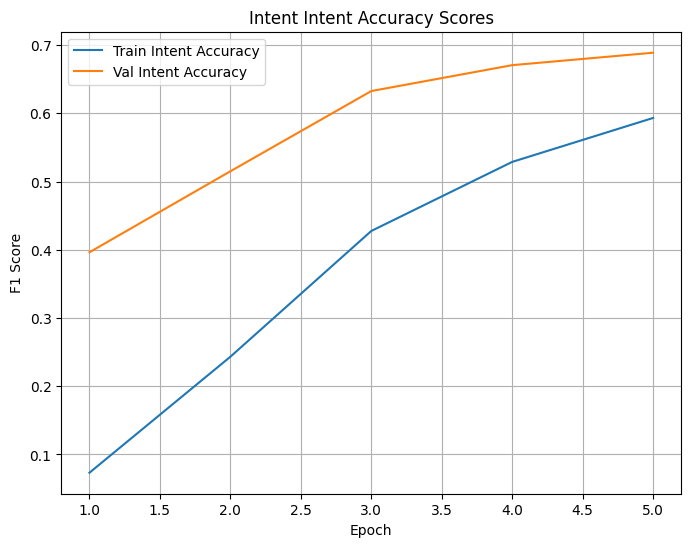

Intent Confusion Matrix saved to /content/drive/MyDrive/gpt2_baseline_model_freeze_d2/intent_cm.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

SAVE_PATH = "/content/drive/MyDrive/gpt2_baseline_model_freeze_d2"

# Load data
with open(os.path.join(SAVE_PATH, "training_metrics.json"), "r") as f:
    metrics = json.load(f)
with open(os.path.join(SAVE_PATH, "test_results.json"), "r") as f:
    test_results = json.load(f)

# Intent Intent Accuracy Scores Plot
epochs = range(1, len(metrics["train_intent_acc"]) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_intent_acc"], label="Train Intent Accuracy")
plt.plot(epochs, metrics["val_intent_acc"], label="Val Intent Accuracy")
plt.title("Intent Intent Accuracy Scores")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "Intent_f1_plot.png"))
plt.show()
plt.close()

# Plot confusion matrices
# INTENT Confusion Matrixplt.figure(figsize=(8, 6))
sns.heatmap(test_results["intent_cm"], annot=True, fmt='d', cmap='Blues')
plt.title("Intent Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
intent_cm_path = os.path.join(SAVE_PATH, "intent_cm.png")
plt.savefig(intent_cm_path)
plt.close()
print(f"Intent Confusion Matrix saved to {intent_cm_path}")


## Category Evaluation (Weighted F1 Plot + Confusion Matrix)


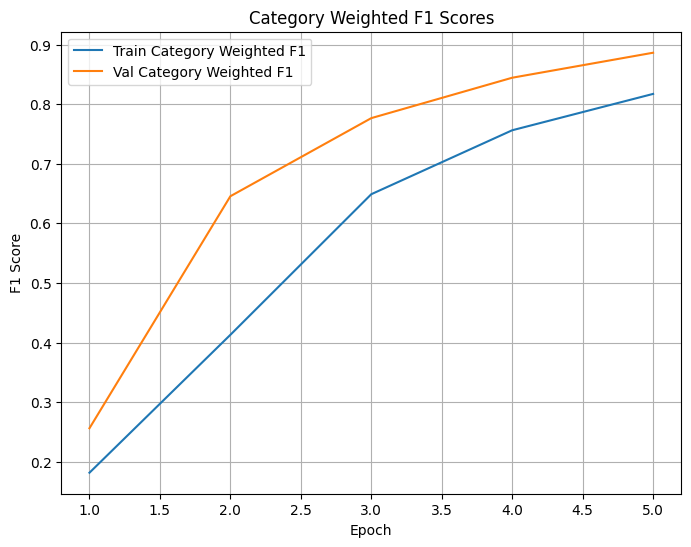

Category Confusion Matrix saved to /content/drive/MyDrive/gpt2_baseline_model_freeze_d2/category_cm.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

SAVE_PATH = "/content/drive/MyDrive/gpt2_baseline_model_freeze_d2"

# Load data
with open(os.path.join(SAVE_PATH, "training_metrics.json"), "r") as f:
    metrics = json.load(f)
with open(os.path.join(SAVE_PATH, "test_results.json"), "r") as f:
    test_results = json.load(f)

# Category Weighted F1 Plot
epochs = range(1, len(metrics["train_category_f1"]) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_category_f1"], label="Train Category Weighted F1")
plt.plot(epochs, metrics["val_category_f1"], label="Val Category Weighted F1")
plt.title("Category Weighted F1 Scores")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "category_f1_plot.png"))
plt.show()
plt.close()

# CATEGORY Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_results["category_cm"], annot=True, fmt='d', cmap='Blues')
plt.title("Category Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
category_cm_path = os.path.join(SAVE_PATH, "category_cm.png")
plt.savefig(category_cm_path)
plt.close()
print(f"Category Confusion Matrix saved to {category_cm_path}")


## NER Evaluation (F1 Plot)


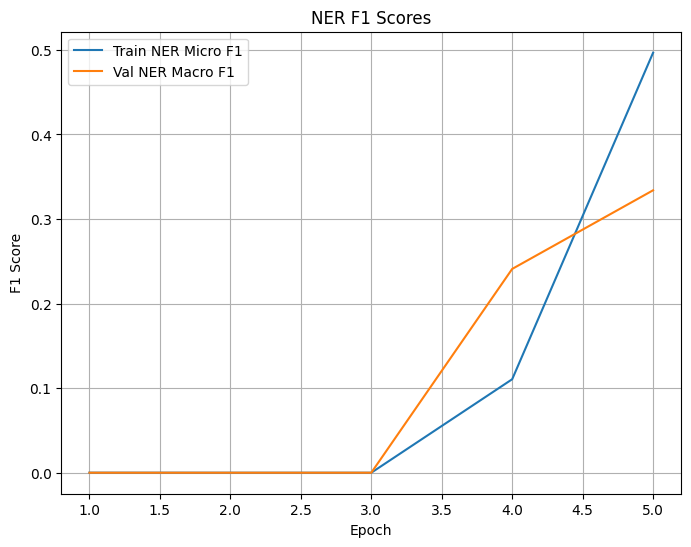

NER plot saved to /content/drive/MyDrive/gpt2_baseline_model_freeze_d2


In [ ]:
import matplotlib.pyplot as plt
import json
import os

SAVE_PATH = "/content/drive/MyDrive/gpt2_baseline_model_freeze_d2"

# Load data
with open(os.path.join(SAVE_PATH, "training_metrics.json"), "r") as f:
    metrics = json.load(f)

# NER F1 Plot
epochs = range(1, len(metrics["train_ner_micro_f1"]) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, metrics["train_ner_micro_f1"], label="Train NER Micro F1")
plt.plot(epochs, metrics["val_ner_macro_f1"], label="Val NER Macro F1")
plt.title("NER F1 Scores")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(SAVE_PATH, "ner_f1_plot.png"))
plt.show()
plt.close()
print(f"NER plot saved to {SAVE_PATH}")

# Note: NER confusion matrix is not typically plotted due to sequence nature; use sequence-level metrics instead
